In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [510 kB]
Get:12 http://security.ubuntu.c

In [2]:
# First, enter the following code to download a Postgres driver that will allow Spark to interact with Postgres:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-08-06 07:46:38--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  5.56MB/s    in 0.2s    

2021-08-06 07:46:38 (5.56 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Regression_DeepLearning").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://tq2cutebucket.s3.us-west-1.amazonaws.com/sale_data.csv"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("sale_data.csv"), sep=",", header=True, inferSchema=True)
df = df.sort("MLS_Number")
df.show()

+-----------+------+------------+---------+--------+---------+----------+---------+---------+---+----------+---+---------+---------+--------------+----------+----------+
| MLS_Number|county|County_Index|SqFtTotal|Lot_Size|BedsTotal|BathsTotal|BathsFull|BathsHalf|Age|Year_Built|DOM|Year_Sold|Year_List|     Sale_Date|List_Price|Sale_Price|
+-----------+------+------------+---------+--------+---------+----------+---------+---------+---+----------+---+---------+---------+--------------+----------+----------+
|BA321014028|Sonoma|          20|     1520|  4400.0|        3|         2|        2|        0| 22|      1999|  0|     2021|     2021|5/23/2021 0:00|    629000|    650000|
|BA321014324| Marin|          15|     2419|  7479.0|        4|         3|        3|        0| 58|      1963|  9|     2021|     2021|5/27/2021 0:00|   1299000|   1460000|
|BA321015460|Solano|          16|     1226|  8969.0|        3|         2|        2|        0| 36|      1985| 37|     2021|     2021|3/10/2021 0:00|   

**Input the number of counties you want to run test**<br>

In [5]:
df = df.select('county','County_Index','SqFtTotal','Lot_Size', 'BedsTotal','BathsTotal',"Age",'Year_Built','DOM','Year_Sold','Sale_Price')
data_df = df.filter("County_Index < 10")
data_df.count()

3064

In [6]:
data_df.show()

+------------+------------+---------+--------+---------+----------+---+----------+---+---------+----------+
|      county|County_Index|SqFtTotal|Lot_Size|BedsTotal|BathsTotal|Age|Year_Built|DOM|Year_Sold|Sale_Price|
+------------+------------+---------+--------+---------+----------+---+----------+---+---------+----------+
|Contra Costa|           6|     1967|  8512.0|        4|         2| 23|      1998|  4|     2021|    620000|
|Contra Costa|           6|     1933| 12001.0|        4|         2| 58|      1963|  8|     2021|    801800|
|     Alameda|           8|     1485|  5854.0|        3|         2| 53|      1968|  2|     2021|   1210000|
|Contra Costa|           6|     2864|  8298.0|        4|         3| 16|      2005|  7|     2021|    800000|
|Contra Costa|           6|     3620|  7640.0|        5|         3| 16|      2005|  0|     2021|    775000|
|     Alameda|           8|      850|  5200.0|        2|         1| 74|      1947|  5|     2021|    652000|
|Contra Costa|           6| 

**Purpose**<br> Given the same data set and the same number of test sample, run both Regression and Neural Network

In [7]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [8]:
data_array = np.array(data_df.collect())

In [9]:
X = data_array[:,1:10]
y = data_array[:,10:11]

In [10]:
#your_array = your_array.astype(np.float64)
X = X.astype(np.float64)
y = y.astype(np.float64)
X

array([[6.0000e+00, 1.9670e+03, 8.5120e+03, ..., 1.9980e+03, 4.0000e+00,
        2.0210e+03],
       [6.0000e+00, 1.9330e+03, 1.2001e+04, ..., 1.9630e+03, 8.0000e+00,
        2.0210e+03],
       [8.0000e+00, 1.4850e+03, 5.8540e+03, ..., 1.9680e+03, 2.0000e+00,
        2.0210e+03],
       ...,
       [0.0000e+00, 7.8000e+02, 1.3932e+04, ..., 1.9380e+03, 3.3000e+01,
        2.0210e+03],
       [0.0000e+00, 2.1590e+03, 3.7723e+04, ..., 1.9500e+03, 7.0000e+00,
        2.0210e+03],
       [0.0000e+00, 8.9180e+03, 1.3074e+04, ..., 2.0080e+03, 1.0000e+00,
        2.0210e+03]])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=10)

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3002, 9) (62, 9) (3002, 1) (62, 1)


**REGRESSION begins**

In [13]:
# Fit ML Regression to a traing set
# Note: intercept is set to zero
from sklearn.linear_model import LinearRegression
regression = LinearRegression(fit_intercept=False)
regression.fit(X_train, y_train)

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [14]:
# Predicting the test result
y_pred = regression.predict(X_test)

In [15]:
#df = pd.DataFrame.from_records([{ 'A':a,'B':b }], index='A')
import pandas as pd
regression_result_df = pd.DataFrame({"Sale_Price": [x[0] for x in y_test], "Reg_Prediction": [x[0] for x in y_pred]})
regression_result_df['Reg_Prediction'] = regression_result_df['Reg_Prediction'].map('{:,.2f}'.format)
regression_result_df.head(10)

,Sale_Price,Reg_Prediction
0,925000.0,"1,197,152.87"
1,765000.0,"628,717.69"
2,775000.0,"1,232,569.11"
3,317000.0,"565,970.83"
4,685000.0,"641,230.62"
5,2100000.0,"2,239,918.12"
6,286000.0,"287,004.25"
7,650000.0,"961,617.31"
8,460000.0,"215,969.97"
9,1500000.0,"904,590.83"


In [16]:
# Built the dataframe of tested rows
import pandas as pd

# Built the dataframe of tested items. Select the column needed
# Need this dataframe later to append the talbe of testing variables
county_index_pyspark = df.select('county','County_Index').drop_duplicates().sort('county')

#pandasDF = pysparkDF.toPandas()
county_index_df = county_index_pyspark.toPandas()

# create a panda df from the X_test information
test_data_df = pd.DataFrame(X_test,columns=['County_Index','SqFtTotal','Lot_Size', 'BedsTotal','BathsTotal',"Age",'Year_Built','DOM','Year_Sold'])

#df = pd.DataFrame.from_records([{ 'A':a,'B':b }], index='A')
regression_result_df = pd.DataFrame({"Sale_Price": [x[0] for x in y_test], "Reg_Prediction": [x[0] for x in y_pred]})
regression_result_df['Reg_Prediction'] = regression_result_df['Reg_Prediction'].map('{:,.2f}'.format)
regression_result_df.head(10)

# This is the final data frame. Merge two df to match the independent variables and the predicted price
regression_result_data_df = test_data_df.merge(regression_result_df, how='left', left_index=True, right_index=True)

#result = pd.merge(left, right, on="key")
final_regression_df = pd.merge(county_index_df, regression_result_data_df, on="County_Index")
final_regression_df.head(10)

#pandasDF = pysparkDF.toPandas()
#sparkDF=spark.createDataFrame(pandasDF)
#reg_test_prediction_df = spark.createDataFrame(final_add_county_df)
#reg_test_prediction_df.show(10)

,county,County_Index,SqFtTotal,Lot_Size,BedsTotal,BathsTotal,Age,Year_Built,DOM,Year_Sold,Sale_Price,Reg_Prediction
0,Alameda,8,2242.0,3915.0,4.0,3.0,13.0,2008.0,6.0,2021.0,1587000.0,"979,768.78"
1,Alameda,8,1159.0,6500.0,3.0,2.0,56.0,1965.0,5.0,2021.0,1200000.0,"722,895.54"
2,Alameda,8,1989.0,7985.0,3.0,3.0,48.0,1973.0,6.0,2021.0,1535000.0,"1,474,622.49"
3,Contra Costa,6,1714.0,6700.0,4.0,3.0,65.0,1956.0,7.0,2021.0,925000.0,"1,197,152.87"
4,Contra Costa,6,2041.0,6800.0,4.0,3.0,48.0,1973.0,6.0,2021.0,775000.0,"1,232,569.11"
5,Contra Costa,6,932.0,5000.0,3.0,1.0,75.0,1946.0,7.0,2021.0,317000.0,"565,970.83"
6,Contra Costa,6,1677.0,9800.0,4.0,2.0,58.0,1963.0,5.0,2021.0,1500000.0,"904,590.83"
7,Contra Costa,6,2448.0,13939.0,5.0,3.0,57.0,1964.0,0.0,2021.0,1600000.0,"1,491,598.48"
8,Contra Costa,6,1602.0,8649.0,3.0,2.0,67.0,1954.0,9.0,2021.0,1675000.0,"1,182,330.50"
9,Los Angeles,0,1197.0,7840.0,3.0,2.0,68.0,1953.0,4.0,2021.0,765000.0,"628,717.69"


In [17]:
# Print out the interceptor
# Expect intercept has to be zero
print("Regression Intercept: " + str(regression.intercept_))

Regression Intercept: 0.0


In [18]:
# Print out the coefficents
print("Regression Coefficients: " + str(regression.coef_))
#print(regression.coef_)

Regression Coefficients: [[ 3.70768342e+04  8.48314417e+02  1.75031985e-03 -2.12009980e+05
   1.60969319e+05 -1.62018533e+05 -1.76231681e+05  3.59239779e+02
   1.75716803e+05]]


In [19]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#
print("MSE -- Regression: " + str(mean_squared_error(y_test, y_pred)))
print("r2 -- Regression: " + str(r2_score(y_test, y_pred)))

MSE -- Regression: 168323272666.91016
r2 -- Regression: 0.20895416302220204


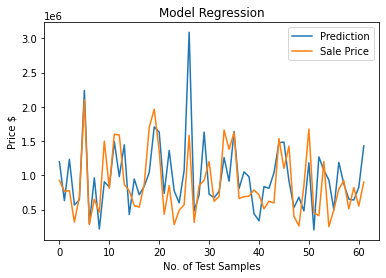

In [20]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test)
plt.title('Model Regression')
plt.ylabel('Price $')
plt.xlabel('No. of Test Samples')
plt.legend(['Prediction', 'Sale Price'], loc='upper right')
plt.show()

**END REGRESSION**

**NEURAL NETWORK begins**

In [21]:
from keras.models import Sequential
from keras.layers import Dense

In [22]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3002, 9) (62, 9) (3002, 1) (62, 1)


In [23]:
model = Sequential([
    Dense(10, activation='relu', input_shape=(9,)),
    Dense(1, activation='relu'),
])


In [24]:
model.compile(optimizer='Adam',
              loss='MSE',
              metrics=['MSE'])

In [25]:
hist = model.fit(X_train, y_train,
          batch_size=32, epochs=50,
          validation_data=(X_test, y_test))

Epoch 1/50
94/94 [==============================] - 15s 6ms/step - loss: 2137404420915.2000 - MSE: 2137404420915.2000 - val_loss: 978258493440.0000 - val_MSE: 978258493440.0000
Epoch 2/50
94/94 [==============================] - 0s 1ms/step - loss: 2461238097898.4419 - MSE: 2461238097898.4419 - val_loss: 971180539904.0000 - val_MSE: 971180539904.0000
Epoch 3/50
94/94 [==============================] - 0s 1ms/step - loss: 2372487119192.9263 - MSE: 2372487119192.9263 - val_loss: 959696928768.0000 - val_MSE: 959696928768.0000
Epoch 4/50
94/94 [==============================] - 0s 2ms/step - loss: 2741772422521.2632 - MSE: 2741772422521.2632 - val_loss: 954530922496.0000 - val_MSE: 954530922496.0000
Epoch 5/50
94/94 [==============================] - 0s 1ms/step - loss: 2834829964945.5156 - MSE: 2834829964945.5156 - val_loss: 951133274112.0000 - val_MSE: 951133274112.0000
Epoch 6/50
94/94 [==============================] - 0s 2ms/step - loss: 2107010595656.7578 - MSE: 2107010595656.7578 - 

In [26]:
# the predict() method is used to generate predictions
y_pred2 = model.predict(X_test)
#print(y_pred2)

In [27]:
#df = pd.DataFrame.from_records([{ 'A':a,'B':b }], index='A')
import pandas as pd
dl_result_df = pd.DataFrame({"Sale_Price": [x[0] for x in y_test], "DL_Prediction": [x[0] for x in y_pred2]})
dl_result_df['DL_Prediction'] = dl_result_df['DL_Prediction'].map('{:,.2f}'.format)
dl_result_df.head(10)

,Sale_Price,DL_Prediction
0,925000.0,"267,175.06"
1,765000.0,"244,343.75"
2,775000.0,"281,314.38"
3,317000.0,"233,338.75"
4,685000.0,"244,349.95"
5,2100000.0,"352,419.03"
6,286000.0,"233,390.33"
7,650000.0,"287,029.19"
8,460000.0,"250,984.67"
9,1500000.0,"265,350.62"


In [28]:
#result = pd.merge(left, right, on="key")
final_regression_deeplearning_df = pd.merge(final_regression_df, dl_result_df, on="Sale_Price")
#final_regression_deeplearning_df.head(10)

#pandasDF = pysparkDF.toPandas()
#sparkDF=spark.createDataFrame(pandasDF)
regression_dl_pandasDF = spark.createDataFrame(final_regression_deeplearning_df)
regression_dl_pandasDF.show(10)
regression_dl_pandasDF.count()

+------------+------------+---------+--------+---------+----------+----+----------+----+---------+----------+--------------+-------------+
|      county|County_Index|SqFtTotal|Lot_Size|BedsTotal|BathsTotal| Age|Year_Built| DOM|Year_Sold|Sale_Price|Reg_Prediction|DL_Prediction|
+------------+------------+---------+--------+---------+----------+----+----------+----+---------+----------+--------------+-------------+
|     Alameda|           8|   2242.0|  3915.0|      4.0|       3.0|13.0|    2008.0| 6.0|   2021.0| 1587000.0|    979,768.78|   290,348.34|
|     Alameda|           8|   1159.0|  6500.0|      3.0|       2.0|56.0|    1965.0| 5.0|   2021.0| 1200000.0|    722,895.54|   243,206.58|
|     Alameda|           8|   1159.0|  6500.0|      3.0|       2.0|56.0|    1965.0| 5.0|   2021.0| 1200000.0|    722,895.54|   301,698.81|
|      Orange|           2|   2507.0|  4066.0|      4.0|       4.0| 8.0|    2013.0|10.0|   2021.0| 1200000.0|  1,073,451.90|   243,206.58|
|      Orange|           2|

70

In [29]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#
print("MSE -- Deep Learning: " + str(mean_squared_error(y_test, y_pred2)))
print("r2 -- Deep Learning: " + str(r2_score(y_test, y_pred2)))

MSE -- Deep Learning: 565516992044.5883
r2 -- Deep Learning: -1.6576827743976028


**When R2 is negative ==> something is wrong**

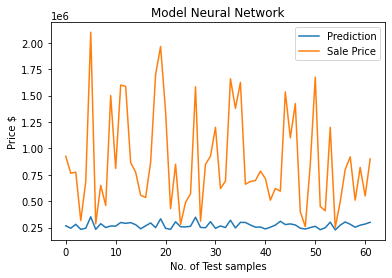

In [30]:
import matplotlib.pyplot as plt
plt.plot(y_pred2)
plt.plot(y_test)
plt.title('Model Neural Network')
plt.ylabel('Price $')
plt.xlabel('No. of Test samples')
plt.legend(['Prediction', 'Sale Price'], loc='upper right')
plt.show()

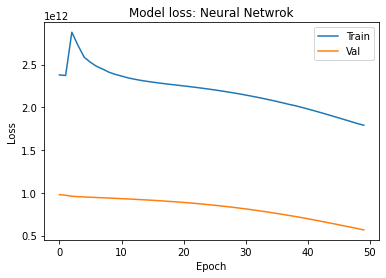

In [31]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss: Neural Netwrok')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

**END**

**Activate next two cells if want to store the dataframe**

In [32]:
# Store environmental variable
from getpass import getpass
password = getpass('Enter database password')
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://database-1.cvmp56um73d3.us-west-1.rds.amazonaws.com:5432/Final_Project_db"
config = {"user":"postgres",
          "password": password,
          "driver":"org.postgresql.Driver"}

# Write DataFrame to house table in RDS
# export_prediction_df.write.jdbc(url=jdbc_url, table='final_data_prediction', mode=mode, properties=config)

Enter database password··········


In [33]:
# Write DataFrame to house table in RDS
regression_dl_pandasDF.write.jdbc(url=jdbc_url, table='Regression_Neural_Network', mode=mode, properties=config)
type(regression_dl_pandasDF)

pyspark.sql.dataframe.DataFrame